In [11]:
import pandas as pd
import os
import matplotlib.pyplot as plt
from matplotlib import colors, cm
import numpy as np
import geopandas as gpd
import rasterio
from rasterio.plot import show, adjust_band
from mpl_toolkits.axes_grid1 import make_axes_locatable
import matplotlib.patches as mpatches

import matplotlib.ticker as ticker 
from shapely import Point
import string
from scipy import interpolate

In [12]:
s2_image_path = '../data/force_balance_figure/s2_image/S2A_MSIL2A_20160504T142012_R096_T24WWU_20210211T083127_3413_clip.tif'
force_path = '../data/force_balance_figure/forces_out_smooth_strain_True_2_smooth_ressitive_True_1.6_smooth_driving_True_1.6_nan_mask_smooth_surf_H_output_surface_rate_factor_250_Bl_210_CROP_proper_mask_no_vel_interp_v2/20160504T142054_20160515T020555_force_balance_smooth_2.tif'
gz_2018_path = '../data/ground_lines_and_grounding_zones/grounding_zones/2018_grounding_zone_convex_hull.gpkg'
gz_2019_path = '../data/ground_lines_and_grounding_zones/grounding_zones/2019_grounding_zone_convex_hull.gpkg'
profile_plot = '../data/ground_lines_and_grounding_zones/profile/td_tb_profile_test.shp'
surface_depression_origin_path = '../data/surface_depression_origins/2015-2022_merged_w_atlas_north_good_quality.gpkg'


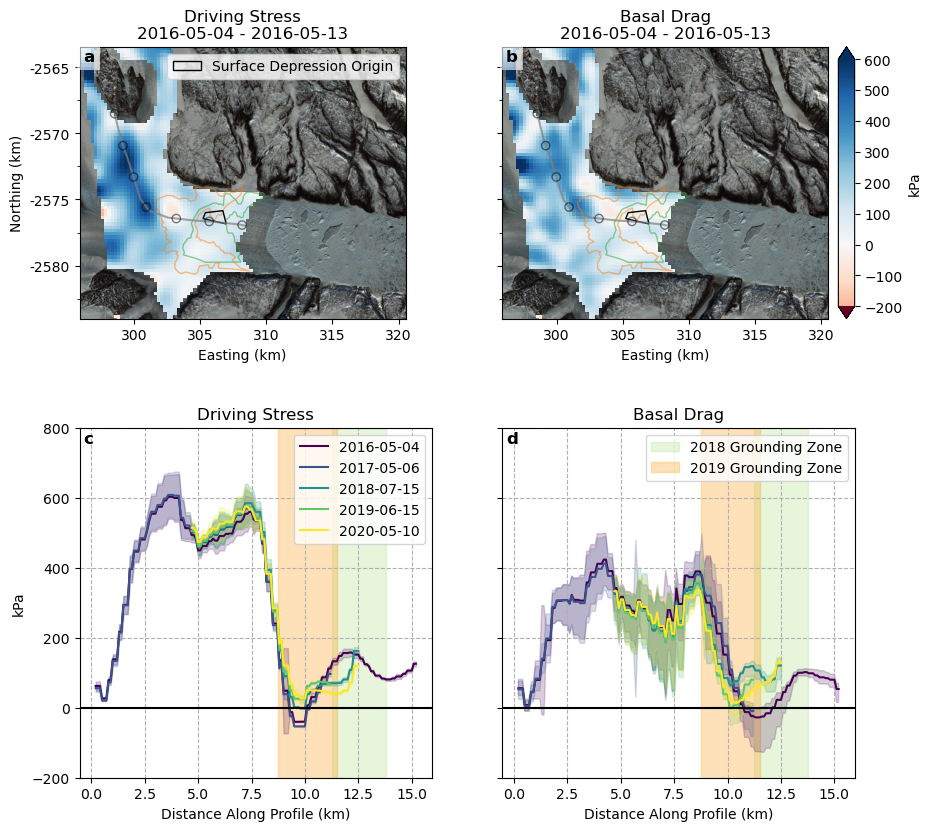

In [13]:
profile = gpd.read_file(profile_plot)
gz_2018 = gpd.read_file(gz_2018_path) # #b2df8a
gz_2019 = gpd.read_file(gz_2019_path) # ##ff9e17
surface_depression_origins = gpd.read_file(surface_depression_origin_path)
surface_depression_origins = surface_depression_origins.dissolve().convex_hull
color_18 = '#b2df8a'
color_19 = '#ff9e17'
sd_color ='#e5b636' #surface depression color

fig, axs = plt.subplots(2,2, figsize=(10,10),sharey='row')

axs = axs.flatten()
top_row = axs[:2]
bottom_row = axs[2:]

#  2016-05-04 - 2016-05-13

vmin, vmax = -600, 600
cmap = 'RdBu'
m2km = lambda x, _: f'{x/1000:g}'
titles = ['Driving Stress\n2016-05-04 - 2016-05-13', 'Basal Drag\n2016-05-04 - 2016-05-13']
top_row_xlim = (295890.09326965094, 320535.67441435)
top_row_ylim = (-2584013.909510022, -2563459.04931128)
for i,ax in enumerate(top_row):
    
    if i == 0:
        band = 11 
    else:
        band = 13
        
        
        
    # plot grounding zone
    profile.plot(ax=ax, color='gray',zorder=4, alpha=0.7)
    gz_2018.plot(ax=ax, facecolor="none", edgecolor = 'tab:green', alpha=0.5,zorder=3, label='2018 Grounding Zone', legend=True, linewidth = 1)
    gz_2019.plot(ax=ax, facecolor="none", edgecolor = 'tab:orange', alpha=0.5,zorder=3,  label='2019 Grounding Zone', legend=True, linewidth = 1)
    surface_depression_origins.plot(ax=ax,zorder=3, edgecolor='k', 
                                    markersize = 20, facecolor='none', label='Surface Depression Origin')
    
    with rasterio.open(force_path) as src_force:
        force_band = src_force.read(band)
        force_band = np.where(force_band==0,np.nan, force_band)
        force_show = show(force_band, adjust=True, ax=ax, transform=src_force.transform,zorder=2,
             vmin=vmin, vmax=vmax, cmap = cmap)
    
    with rasterio.open(s2_image_path) as src:
        
        show(src.read([1,2,3]),adjust=True, ax=ax, transform=src.transform,
             zorder=1)

        ax.xaxis.set_major_formatter(m2km)
        ax.yaxis.set_major_formatter(m2km)
        
    ax.set_xlabel('Easting (km)')
    ax.set_title(titles[i])
    ax.set_xlim(top_row_xlim)
    ax.set_ylim(top_row_ylim)

#%% add 2 km points to profile

distance_delta = 2.5e3
distances_points = np.arange(0, profile.geometry.length[0], distance_delta)

interp_points = [list(profile.geometry.interpolate(distance).geometry[0].coords)[0] for distance in distances_points]
x,y = zip(*interp_points)
points = gpd.points_from_xy(x,y)
points = gpd.GeoSeries(points,crs=3413)
points.plot(ax=top_row[0], facecolor="none", edgecolor = 'k', alpha=0.5,zorder=5)
points.plot(ax=top_row[1], facecolor="none", edgecolor = 'k', alpha=0.5,zorder=5)
gdf = gpd.GeoDataFrame(points)
gdf['distance'] = distances_points

surface_depression_path = mpatches.Patch(color = None, facecolor = None, fill = False,
                                         label = 'Surface Depression Origin', edgecolor = 'k')
top_row[0].legend(handles=[surface_depression_path])


div1 = make_axes_locatable(top_row[0])
cax = div1.append_axes("right", size="5%", pad=0.1)
cbar = fig.colorbar(cm.ScalarMappable(norm=colors.Normalize(vmin = vmin,vmax = vmax), cmap=cmap),
              cax=cax, **{'extend':'max'})
cax.set_visible(False)


div2 = make_axes_locatable(ax)
cax2 = div2.append_axes("right", size="5%", pad=0.1)
cbar2 = fig.colorbar(cm.ScalarMappable(norm=colors.Normalize(vmin = vmin,vmax = vmax), cmap=cmap),
              cax=cax2, **{'extend':'both'})

cbar2.set_label(label='kPa')
# fig.colorbar(force_show, ax=ax)    
cbar2.ax.set_ylim(-200, vmax)
top_row[0].set_ylabel('Northing (km)')
space=5e3
top_row[0].xaxis.set_major_locator(ticker.MultipleLocator(space)) 
top_row[0].yaxis.set_major_locator(ticker.MultipleLocator(space)) 
        
#%%
# Bottom row
def rm_geo(df):
    
    df = df.drop('geometry', axis=1)
    df.columns = pd.to_datetime(df.columns)
    df.sort_index(axis=1,inplace=True)
    
    return df
    

td_path = '../data/force_balance_figure/force_balance_clip/Td_along.pkl' 
tb_path = '../data/force_balance_figure/force_balance_clip/Tb_along.pkl' 
td_error_path = '../data/force_balance_figure/errors/force_balance_smooth_2_driving_stress_error.pkl'
tb_error_path = '../data/force_balance_figure/errors/basal_drag_error_add.pkl'

B_185_path = '../data/force_balance_figure/force_balance_B185_Bl185/Tb_along.pkl'
B_350_path = '../data/force_balance_figure/force_balance_B350_Bl350/Tb_along.pkl'

Td_df = pd.read_pickle(td_path)
Tb_df = pd.read_pickle(tb_path)


td_error_vals = rm_geo(pd.read_pickle(td_error_path))
tb_error_vals = rm_geo(pd.read_pickle(tb_error_path))

td_error_vals = td_error_vals.iloc[:,:-1]
tb_error_vals = tb_error_vals.iloc[:,:-1]


B185 = rm_geo(pd.read_pickle(B_185_path))
B350 = rm_geo(pd.read_pickle(B_350_path))




# get bounds for grounding zones
profile_18 = profile.intersection(gz_2018)
profile_19 = profile.intersection(gz_2019)

profile_18_coords = list(profile_18[0].coords)
profile_19_coords = list(profile_19[0].coords)


cmap = plt.get_cmap('viridis')

# Generate a list of N colors from the colormap
N = 5
colors = cmap(np.linspace(0, 1, N))

distance_along_profile = np.arange(0, profile.geometry.length[0], 100)
dist_km = distance_along_profile/1e3


# make function to find upper and lower bound of entire dataframe
def get_end_members(tb_df, error_df, B350_df, B185_df, km_index):
    
    tb_df = rm_geo(tb_df)
    tb_df.columns = error_df.columns
    tb_df.index = km_index
    error_df.index = km_index
    
    upper_bound_df = tb_df + error_df
    lower_bound_df = tb_df - error_df
    
    B350_df.columns = error_df.columns
    B185_df.columns = error_df.columns

    
    msk_upper_385 = upper_bound_df < B350_df
    msk_lower_385 = B350_df < lower_bound_df
    
    upper_bound_385 = upper_bound_df.where( ~msk_upper_385, upper_bound_df + (B350_df - upper_bound_df) )
    lower_bound_385 = lower_bound_df.where( ~msk_lower_385, lower_bound_df - (lower_bound_df - B350_df) )
    
    
    
    msk_upper_185 = upper_bound_385 < B185_df
    msk_lower_185 = B185_df < lower_bound_385
    
    upper_bound_185 = upper_bound_385.where(~msk_upper_185, upper_bound_385 + (B185_df - upper_bound_385) )
    lower_bound_185 = lower_bound_385.where(~msk_lower_185, lower_bound_385 - (lower_bound_385 - B185_df) )
    
    return upper_bound_185, lower_bound_185




B350.index = dist_km
B185.index = dist_km
B350.iloc[-1,0] = np.nan
B185.iloc[-1,0] = np.nan

date_2016 = pd.to_datetime('2016-05-04 14:20:54')

# need to do this for all dates
bounded_tb_error = get_end_members(Tb_df, tb_error_vals, B350.iloc[:,:-1], B185.iloc[:,:-1], dist_km)




# clean up from edge effects
forces_list = [ 
                (Td_df, td_error_vals),
               (Tb_df, bounded_tb_error)
              
               ]



for i, (df,err_df) in enumerate(forces_list):
    
    
    ax = bottom_row[i]
    
    first_point = df['geometry'][0]

    min_18_dist = profile.project(Point(profile_18_coords[0]))[0]
    max_18_dist = profile.project(Point(profile_18_coords[-1]))[0]
    
    min_19_dist = profile.project(Point(profile_19_coords[0]))[0]
    max_19_dist = profile.project(Point(profile_19_coords[-1]))[0]
    
    
    
    ax.axvspan(min_18_dist/1000, max_18_dist/1000, color=color_18, alpha = 0.3, 
               zorder=1, label='2018 Grounding Zone')
    
    ax.axvspan(min_19_dist/1000, max_19_dist/1000, color=color_19, alpha = 0.3, 
               zorder=1, label='2019 Grounding Zone')
    
    
    df_dt = df.iloc[:,1:]
    df_dt.columns = pd.to_datetime(df_dt.columns)
    df_dt.columns = df_dt.columns.date
    

    
    df_dt.sort_index(axis=1,inplace=True)
    df_dt.index = dist_km
    df_dt
    # clean up small area data
    # first the upflow portion at 4.7km
    mask_1820 = df_dt.index<4.7
    df_dt.iloc[mask_1820,2:] = np.nan
    
    mask_17 = df_dt.index>11.2
    df_dt.iloc[mask_17,1] = np.nan
    df_dt.where(df_dt!=0, inplace = True)
    df_dt.plot(cmap='viridis', ax=ax, legend=False)
    
    if i == 1:
        upper_bound_tb_err, lower_bound_tb_err =  err_df
        upper_bound_tb_err.columns = df_dt.columns
        lower_bound_tb_err.columns = df_dt.columns
        
        for j,col in enumerate(upper_bound_tb_err):
            
            first_valid_index = df_dt.loc[:,col].first_valid_index()
            last_valid_index = df_dt.loc[:,col].last_valid_index()
            
            lb = lower_bound_tb_err.loc[first_valid_index:last_valid_index,col]
            ub = upper_bound_tb_err.loc[first_valid_index:last_valid_index,col]
            lb = lb.where(lb>-200, np.nan)
            ub = ub.where(ub<800, np.nan)
            
            ax.fill_between(lb.index, lb, 
                            ub,
                              alpha=0.2, color=colors[j])
    
    else:
        err_df.index = dist_km
        err_df.columns = err_df.columns.date
        
        for j,col in enumerate(err_df):
            ax.fill_between(dist_km, df_dt.loc[:,col] - err_df.loc[:,col], 
                             df_dt.loc[:,col] + err_df.loc[:,col],
                              alpha=0.2, color=colors[j])
                
    ax.set_ylim(-400,1200)
    

titles_bottom = ['Driving Stress', 'Basal Drag']
# asp = np.diff(bottom_row[0].get_xlim())[0] / np.diff(bottom_row[0].get_ylim())[0]
# asp /= np.abs(np.diff(top_row[0].get_xlim())[0] / np.diff(top_row[0].get_ylim())[0])

# plot different b levels
# B350.iloc[:,0].plot(ax=ax, legend=False, color='k', linestyle='--')
# B185.iloc[:,0].plot(ax=ax, legend=False, color='gray', linestyle='--')

for i,bax in enumerate(bottom_row):
    # bax.set_aspect(asp)
    bax.grid(linestyle = '--')
    bax.set_title(titles_bottom[i])
    bax.set_xlabel('Distance Along Profile (km)')
    bax.set_ylim(-200,800)
    bax.axhline(0, color='k')
    
    
bottom_row[0].set_ylabel('kPa')

leg = bottom_row[0].get_legend_handles_labels()

bottom_row[0].legend(handles=leg[0][2:],  labels=leg[1][2:], loc = 'upper right')
bottom_row[1].legend(handles=leg[0][:2],  labels=leg[1][:2], loc = 'upper right')
# plt.subplots_adjust(hspace=0)


alphabet = list(string.ascii_lowercase)
text_dict = {'fontsize':12,
             'fontweight': 'bold'}

for i,axis in enumerate(axs):
    text_label = axis.text(.01, .99, alphabet[i], ha='left', va='top', transform=axis.transAxes, **text_dict)
    
    if i <2:
        text_label.set_bbox(dict(facecolor='white', alpha=0.6, linewidth=0))
    
op = '/media/laserglaciers/upernavik/flexure_manuscipt/figures/'
# fig.savefig(f'{op}force_balance_td_tb_square_sum_FINAL_review.pdf', dpi = 300, bbox_inches='tight')

# plt.tight_layout()
